## MBTA Travel + Wait times

In [3]:
import numpy as np
import calendar
import pandas as pd
from datetime import datetime, timedelta

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

import folium

import requests
import json

In [4]:
# style charts
sns.set()

In [5]:
CLIENT_KEY = ''

In [6]:
# Get all routes:
# http://realtime.mbta.com/developer/api/v2/routes?api_key=yourapikey&format=json

# then get the stop ids for a route
# http://realtime.mbta.com/developer/api/v2/stopsbyroute?api_key= yourapikey&route=routeid&format=json

# Constructing the MBTA Map

## Get all routes

In [7]:
df_routes_raw = pd.read_csv('data/MBTA_GTFS/routes.txt')
df_routes_raw.head()

,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color,route_sort_order,route_fare_class,line_id,listed_route
0,Red,1,NaN,Red Line,Rapid Transit,1,https://www.mbta.com/schedules/Red,DA291C,FFFFFF,10010,Rapid Transit,line-Red,NaN
1,Mattapan,1,NaN,Mattapan Trolley,Rapid Transit,0,https://www.mbta.com/schedules/Mattapan,DA291C,FFFFFF,10011,Rapid Transit,line-Mattapan,NaN
2,Orange,1,NaN,Orange Line,Rapid Transit,1,https://www.mbta.com/schedules/Orange,ED8B00,FFFFFF,10020,Rapid Transit,line-Orange,NaN
3,Green-B,1,B,Green Line B,Rapid Transit,0,https://www.mbta.com/schedules/Green-B,00843D,FFFFFF,10032,Rapid Transit,line-Green,NaN
4,Green-C,1,C,Green Line C,Rapid Transit,0,https://www.mbta.com/schedules/Green-C,00843D,FFFFFF,10033,Rapid Transit,line-Green,NaN


In [8]:
df_routes = df_routes_raw[['route_id', 'route_long_name','route_color']][df_routes_raw.route_desc=='Rapid Transit']
df_routes.set_index('route_id', inplace=True)
df_routes

,route_long_name,route_color
route_id,,
Red,Red Line,DA291C
Mattapan,Mattapan Trolley,DA291C
Orange,Orange Line,ED8B00
Green-B,Green Line B,00843D
Green-C,Green Line C,00843D
Green-D,Green Line D,00843D
Green-E,Green Line E,00843D
Blue,Blue Line,003DA5


## Get all stop_ids

In [52]:
df_stops_raw = pd.read_csv('data/MBTA_GTFS/stops.txt')
df_stops_raw.head()

,stop_id,stop_code,stop_name,stop_desc,platform_code,platform_name,stop_lat,stop_lon,zone_id,stop_address,stop_url,level_id,location_type,parent_station,wheelchair_boarding,municipality,on_street,at_street,vehicle_type
0,1,1.0,Washington St opp Ruggles St,NaN,NaN,NaN,42.330957,-71.082754,NaN,NaN,https://www.mbta.com/stops/1,NaN,0,NaN,1,Boston,Washington Street,Ruggles Street,3.0
1,10,10.0,Theo Glynn Way @ Newmarket Sq,NaN,NaN,NaN,42.330555,-71.068787,NaN,NaN,https://www.mbta.com/stops/10,NaN,0,NaN,1,Boston,Theodore Glynn Way,Newmarket Square,3.0
2,10000,10000.0,Tremont St opp Temple Pl,NaN,NaN,NaN,42.355692,-71.062911,NaN,NaN,https://www.mbta.com/stops/10000,NaN,0,NaN,1,Boston,Tremont Street,Temple Place,3.0
3,10003,10003.0,Albany St opp Randall St,NaN,NaN,NaN,42.331591,-71.076237,NaN,NaN,https://www.mbta.com/stops/10003,NaN,0,NaN,0,Boston,Albany Street,Randall Street,3.0
4,10005,10005.0,Albany St opp E Concord St,NaN,NaN,NaN,42.335017,-71.071280,NaN,NaN,https://www.mbta.com/stops/10005,NaN,0,NaN,1,Boston,Albany Street,East Concord Street,3.0


In [53]:
len(df_stops_raw)

9867

In [59]:
df_stops_raw.dtypes

stop_id                 object
stop_code              float64
stop_name               object
stop_desc               object
platform_code           object
platform_name           object
stop_lat               float64
stop_lon               float64
zone_id                 object
stop_address            object
stop_url                object
level_id                object
location_type            int64
parent_station          object
wheelchair_boarding      int64
municipality            object
on_street               object
at_street               object
vehicle_type           float64
dtype: object

In [54]:
df_stops = df_stops_raw[['stop_id', 'stop_name', 'stop_lat', 'stop_lon']][df_stops_raw.vehicle_type==3.0]
df_stops.set_index('stop_id', inplace=True)
df_stops = df_stops[df_stops.duplicated()==False]
df_stops

,stop_name,stop_lat,stop_lon
stop_id,,,
1,Washington St opp Ruggles St,42.330957,-71.082754
10,Theo Glynn Way @ Newmarket Sq,42.330555,-71.068787
10000,Tremont St opp Temple Pl,42.355692,-71.062911
10003,Albany St opp Randall St,42.331591,-71.076237
10005,Albany St opp E Concord St,42.335017,-71.071280
...,...,...,...
29014,Sullivan Square,42.383917,-71.076089
5271,Wellington Station Busway,42.402581,-71.076089
5666,Wood Island,42.380368,-71.023287


In [61]:
df_stops.loc['74613'] #'70172']

stop_name    World Trade Center
stop_lat                42.3486
stop_lon               -71.0425
Name: 74613, dtype: object

In [62]:
df_stops.loc['70182']

KeyError: '70182'

## Get route connections

In [13]:
df_route_patterns_raw = pd.read_csv('data/MBTA_GTFS/route_patterns.txt')
df_route_patterns_raw.head()

,route_pattern_id,route_id,direction_id,route_pattern_name,route_pattern_time_desc,route_pattern_typicality,route_pattern_sort_order,representative_trip_id
0,Red-1-0,Red,0,Alewife - Ashmont,NaN,1,10010050,43206839
1,Red-3-0,Red,0,Alewife - Braintree,NaN,1,10010051,43206854
2,Red-1-0_70061_70067_2,Red,0,Harvard - Ashmont,NaN,4,10010099,43145895-AlewifeHarvard2
3,Red-3-0_70061_70067_2,Red,0,Harvard - Braintree,NaN,4,10010099,43146066-AlewifeHarvard2
4,Red-1-1,Red,1,Ashmont - Alewife,NaN,1,10010151,43206834


In [14]:
df_route_patterns = df_route_patterns_raw[['route_pattern_id', 'route_id', 'route_pattern_name', 'representative_trip_id']][df_route_patterns_raw.route_id.isin(df_routes.index)]
df_route_patterns.set_index('route_pattern_id', inplace=True)
df_route_patterns.head()

,route_id,route_pattern_name,representative_trip_id
route_pattern_id,,,
Red-1-0,Red,Alewife - Ashmont,43206839
Red-3-0,Red,Alewife - Braintree,43206854
Red-1-0_70061_70067_2,Red,Harvard - Ashmont,43145895-AlewifeHarvard2
Red-3-0_70061_70067_2,Red,Harvard - Braintree,43146066-AlewifeHarvard2
Red-1-1,Red,Ashmont - Alewife,43206834


In [15]:
df_route_patterns.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42 entries, Red-1-0 to Blue-6-1
Data columns (total 3 columns):
route_id                  42 non-null object
route_pattern_name        42 non-null object
representative_trip_id    42 non-null object
dtypes: object(3)
memory usage: 1.3+ KB


In [16]:
# get sequence from trip examples

In [65]:
df_trips_raw = pd.read_csv('data/MBTA_GTFS/trips.txt')
df_trips_raw.head()

,route_id,service_id,trip_id,trip_headsign,trip_short_name,direction_id,block_id,shape_id,wheelchair_accessible,trip_route_type,route_pattern_id,bikes_allowed
0,1,BUS12020-hbc10011-Wdy-02,42844652,Harvard,NaN,0,C01-10,010070,1,NaN,1-_-0,1
1,1,BUS12020-hbc10011-Wdy-02,42844654,Harvard,NaN,0,C01-10,010070,1,NaN,1-_-0,1
2,1,BUS12020-hbc10011-Wdy-02,42844656,Harvard,NaN,0,C01-14,010070,1,NaN,1-_-0,1
3,1,BUS12020-hbc10011-Wdy-02,42844657,Harvard,NaN,0,C01-14,010070,1,NaN,1-_-0,1
4,1,BUS12020-hbc10011-Wdy-02,42844658,Harvard,NaN,0,C01-10,010070,1,NaN,1-_-0,1


In [66]:
df_trips_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69186 entries, 0 to 69185
Data columns (total 12 columns):
route_id                 69186 non-null object
service_id               69186 non-null object
trip_id                  69186 non-null object
trip_headsign            69186 non-null object
trip_short_name          1271 non-null object
direction_id             69186 non-null int64
block_id                 67915 non-null object
shape_id                 69186 non-null object
wheelchair_accessible    69186 non-null int64
trip_route_type          1672 non-null float64
route_pattern_id         69186 non-null object
bikes_allowed            69186 non-null int64
dtypes: float64(1), int64(3), object(8)
memory usage: 6.3+ MB


In [19]:
# df_trips_feed = df_trips_raw[['route_id', 'service_id', 'trip_id', 'direction_id', 'shape_id', 'route_pattern_id']]

In [69]:
# Filter trips feed to find 'representative_trip_id's
df_example_trips = df_trips_raw[df_trips_raw.trip_id.isin(df_route_patterns.representative_trip_id)]
df_example_trips = df_example_trips[['route_pattern_id', 'shape_id', 'trip_id']]
df_example_trips.set_index('trip_id', drop=True, inplace=True)
df_example_trips

,route_pattern_id,shape_id
trip_id,,
42885000,Blue-6-0,946_0013
42885354,Blue-8-0,948_0005
42885177,Blue-6-1,946_0014
43017985,Green-B-3-0,813_0006
43026887,Green-B-0-0,810_0004
43017944,Green-B-3-1,813_0007
43026886,Green-B-0-1,810_0005
43019511,Green-C-0-0,830_0006
43019654,Green-C-1-0,831_0011


In [70]:
len(df_example_trips)

42

In [ ]:
## Get sequence from stop_times

In [71]:
df_stop_times = pd.read_csv('data/MBTA_GTFS/stop_times.txt')
df_stop_times.head()

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0,3,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,timepoint,checkpoint_id
0,42509838,24:30:00,24:30:00,70036,1,NaN,0,1,1.0,NaN
1,42509838,24:32:00,24:32:00,70034,10,NaN,0,0,1.0,NaN
2,42509838,24:35:00,24:35:00,70032,20,NaN,0,0,1.0,NaN
3,42509838,24:37:00,24:37:00,70278,30,NaN,0,0,1.0,NaN
4,42509838,24:40:00,24:40:00,70030,40,NaN,0,0,1.0,NaN


In [72]:
df_stop_times.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1802306 entries, 0 to 1802305
Data columns (total 10 columns):
trip_id           object
arrival_time      object
departure_time    object
stop_id           object
stop_sequence     int64
stop_headsign     float64
pickup_type       int64
drop_off_type     int64
timepoint         float64
checkpoint_id     object
dtypes: float64(2), int64(3), object(5)
memory usage: 137.5+ MB


In [23]:
## Fetch shapes
df_shapes_raw = pd.read_csv('data/MBTA_GTFS/shapes.txt')
df_shapes_raw.head()

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled
0,010058,42.373178,-71.118170,10001,NaN
1,010058,42.373269,-71.118463,10002,NaN
2,010058,42.373353,-71.118582,10003,NaN
3,010058,42.373399,-71.118648,10004,NaN
4,010058,42.373639,-71.118843,10005,NaN


In [24]:
df_example_shapes = df_shapes_raw[df_shapes_raw.shape_id.isin(df_example_trips.shape_id)]
df_example_shapes

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled
262789,810_0004,42.370947,-71.077058,10001,NaN
262790,810_0004,42.370905,-71.076982,10002,NaN
262791,810_0004,42.370836,-71.076858,10003,NaN
262792,810_0004,42.370777,-71.076710,10004,NaN
262793,810_0004,42.370752,-71.076532,10005,NaN
...,...,...,...,...,...
281355,948_0005,42.361034,-71.061562,70015,NaN
281356,948_0005,42.361082,-71.061811,70016,NaN
281357,948_0005,42.361143,-71.062070,70017,NaN
281358,948_0005,42.361162,-71.062150,70018,NaN


In [25]:
# df_example_shapes['location'] = list(zip(df_example_shapes.shape_pt_lat, df_example_shapes.shape_pt_lon))
# df_example_shapes

In [26]:
m = folium.Map(location=[42.3601,-71.0589])

#         popup=name,
# add markers to the map

for s in df_example_shapes.shape_id.unique()[20:25]:
    df_s = df_example_shapes[df_example_shapes.shape_id==s]
    for lat, lon in zip(df_s['shape_pt_lat'], df_s['shape_pt_lon']):
        folium.CircleMarker([lat, lon], radius=3, color='green').add_to(m)
# for lat, lon in zip(route_850_0006['shape_pt_lat'], route_850_0006['shape_pt_lon']):
#     folium.CircleMarker([lat, lon], radius=3, color='green').add_to(m)
# for lat, lon in zip(route_810_0004['shape_pt_lat'], route_810_0004['shape_pt_lon']):
#     folium.CircleMarker([lat, lon], radius=3, color='green').add_to(m)
m

In [27]:
df_example_shapes.loc[:,'shape_sequence_key'] = df_example_shapes.shape_pt_sequence // 10000
df_example_shapes.loc[:,'shape_sequence_val'] = df_example_shapes.shape_pt_sequence % 100
df_example_shapes

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled,shape_sequence_key,shape_sequence_val
262789,810_0004,42.370947,-71.077058,10001,NaN,1,1
262790,810_0004,42.370905,-71.076982,10002,NaN,1,2
262791,810_0004,42.370836,-71.076858,10003,NaN,1,3
262792,810_0004,42.370777,-71.076710,10004,NaN,1,4
262793,810_0004,42.370752,-71.076532,10005,NaN,1,5
...,...,...,...,...,...,...,...
281355,948_0005,42.361034,-71.061562,70015,NaN,7,15
281356,948_0005,42.361082,-71.061811,70016,NaN,7,16
281357,948_0005,42.361143,-71.062070,70017,NaN,7,17
281358,948_0005,42.361162,-71.062150,70018,NaN,7,18


In [28]:
df_example_shapes.shape_sequence_key.value_counts()

2     783
5     748
1     734
4     636
3     635
6     615
7     555
16    535
13    526
15    516
14    485
17    458
10    442
12    437
19    400
11    381
8     340
18    320
9     314
20    190
23    168
21    125
22    106
24     89
27     47
28     38
25     28
26     23
Name: shape_sequence_key, dtype: int64

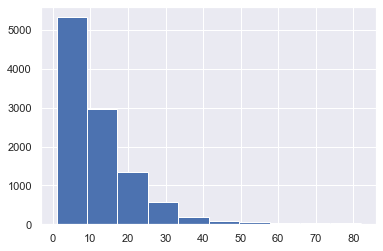

In [29]:
df_example_shapes.shape_sequence_val.hist()

## Get stop times

In [ ]:
df_example_trips 

# Fetch historical performance data

In [46]:
# Prepare date range for querying MBTA API
datelist_2019 = pd.date_range(start='12/30/2018', end='12/31/2019', freq='W')
datelist_2019

DatetimeIndex(['2018-12-30', '2019-01-06', '2019-01-13', '2019-01-20',
               '2019-01-27', '2019-02-03', '2019-02-10', '2019-02-17',
               '2019-02-24', '2019-03-03', '2019-03-10', '2019-03-17',
               '2019-03-24', '2019-03-31', '2019-04-07', '2019-04-14',
               '2019-04-21', '2019-04-28', '2019-05-05', '2019-05-12',
               '2019-05-19', '2019-05-26', '2019-06-02', '2019-06-09',
               '2019-06-16', '2019-06-23', '2019-06-30', '2019-07-07',
               '2019-07-14', '2019-07-21', '2019-07-28', '2019-08-04',
               '2019-08-11', '2019-08-18', '2019-08-25', '2019-09-01',
               '2019-09-08', '2019-09-15', '2019-09-22', '2019-09-29',
               '2019-10-06', '2019-10-13', '2019-10-20', '2019-10-27',
               '2019-11-03', '2019-11-10', '2019-11-17', '2019-11-24',
               '2019-12-01', '2019-12-08', '2019-12-15', '2019-12-22',
               '2019-12-29'],
              dtype='datetime64[ns]', freq='W-S

## Fetch traveltimes for 

In [30]:
def fetch_traveltimes(from_stop, to_stop, from_epoch, to_epoch):
        url = f"http://realtime.mbta.com/developer/api/v2.1/traveltimes?api_key={CLIENT_KEY}&format=json&from_stop={from_stop}&to_stop={to_stop}&from_datetime={from_epoch}&to_datetime={to_epoch}"
        print(url)
        try:
            results = requests.get(url).json()
#             print('results', results)
        except json.decoder.JSONDecodeError as err:
            print('API error: {}'.format(err))
            offset = total
        
        return results

In [32]:
def timestamp_to_epoch(timestamps):
#     We subtract the epoch (midnight at January 1, 1970 UTC) and then floor divide by the “unit” (1 second).
    return (timestamps - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

In [33]:
epochslist_2019 = timestamp_to_epoch(datelist_2019)
epochslist_2019

Int64Index([1546128000, 1546732800, 1547337600, 1547942400, 1548547200,
            1549152000, 1549756800, 1550361600, 1550966400, 1551571200,
            1552176000, 1552780800, 1553385600, 1553990400, 1554595200,
            1555200000, 1555804800, 1556409600, 1557014400, 1557619200,
            1558224000, 1558828800, 1559433600, 1560038400, 1560643200,
            1561248000, 1561852800, 1562457600, 1563062400, 1563667200,
            1564272000, 1564876800, 1565481600, 1566086400, 1566691200,
            1567296000, 1567900800, 1568505600, 1569110400, 1569715200,
            1570320000, 1570924800, 1571529600, 1572134400, 1572739200,
            1573344000, 1573948800, 1574553600, 1575158400, 1575763200,
            1576368000, 1576972800, 1577577600],
           dtype='int64')

In [34]:
results_jan_1 = fetch_mbta_v2(70172, 70182, epochslist_2019[0], epochslist_2019[1]) 
results_jan_1

http://realtime.mbta.com/developer/api/v2.1/traveltimes?api_key=wX9NwuHnZU2ToO7GmGR9uw&format=json&from_stop=70172&to_stop=70182&from_datetime=1546128000&to_datetime=1546732800


{'travel_times': [{'route_id': 'Green-D',
   'direction': '1',
   'dep_dt': '1546128613',
   'arr_dt': '1546128685',
   'travel_time_sec': '72',
   'benchmark_travel_time_sec': '780'},
  {'route_id': 'Green-D',
   'direction': '1',
   'dep_dt': '1546130083',
   'arr_dt': '1546130112',
   'travel_time_sec': '29',
   'benchmark_travel_time_sec': '780'},
  {'route_id': 'Green-D',
   'direction': '1',
   'dep_dt': '1546129885',
   'arr_dt': '1546130456',
   'travel_time_sec': '571',
   'benchmark_travel_time_sec': '780'},
  {'route_id': 'Green-D',
   'direction': '1',
   'dep_dt': '1546130828',
   'arr_dt': '1546131418',
   'travel_time_sec': '590',
   'benchmark_travel_time_sec': '780'},
  {'route_id': 'Green-D',
   'direction': '1',
   'dep_dt': '1546133108',
   'arr_dt': '1546133721',
   'travel_time_sec': '613',
   'benchmark_travel_time_sec': '780'},
  {'route_id': 'Green-D',
   'direction': '1',
   'dep_dt': '1546133625',
   'arr_dt': '1546134238',
   'travel_time_sec': '613',
   'be

In [35]:
df_jan_1 = pd.DataFrame(results_jan_1['travel_times'])
# df_jan_1.direction = df_jan_1.direction.astype(category)
df_jan_1.travel_time_sec = df_jan_1.travel_time_sec.astype(int)
df_jan_1.dep_dt = df_jan_1.dep_dt.apply(lambda x: pd.to_datetime(x, unit='s'))
df_jan_1.arr_dt = df_jan_1.arr_dt.apply(lambda x: pd.to_datetime(x, unit='s'))
df_jan_1.rush_hour = df_jan_1
df_jan_1

,route_id,direction,dep_dt,arr_dt,travel_time_sec,benchmark_travel_time_sec
0,Green-D,1,2018-12-30 00:10:13,2018-12-30 00:11:25,72,780
1,Green-D,1,2018-12-30 00:34:43,2018-12-30 00:35:12,29,780
2,Green-D,1,2018-12-30 00:31:25,2018-12-30 00:40:56,571,780
3,Green-D,1,2018-12-30 00:47:08,2018-12-30 00:56:58,590,780
4,Green-D,1,2018-12-30 01:25:08,2018-12-30 01:35:21,613,780
...,...,...,...,...,...,...
448,Green-D,1,2019-01-05 04:31:23,2019-01-05 04:32:01,38,780
449,Green-D,1,2019-01-05 04:32:49,2019-01-05 04:33:45,56,780
450,Green-D,1,2019-01-05 04:33:37,2019-01-05 04:42:20,523,780
451,Green-D,1,2019-01-05 05:08:30,2019-01-05 05:17:27,537,780


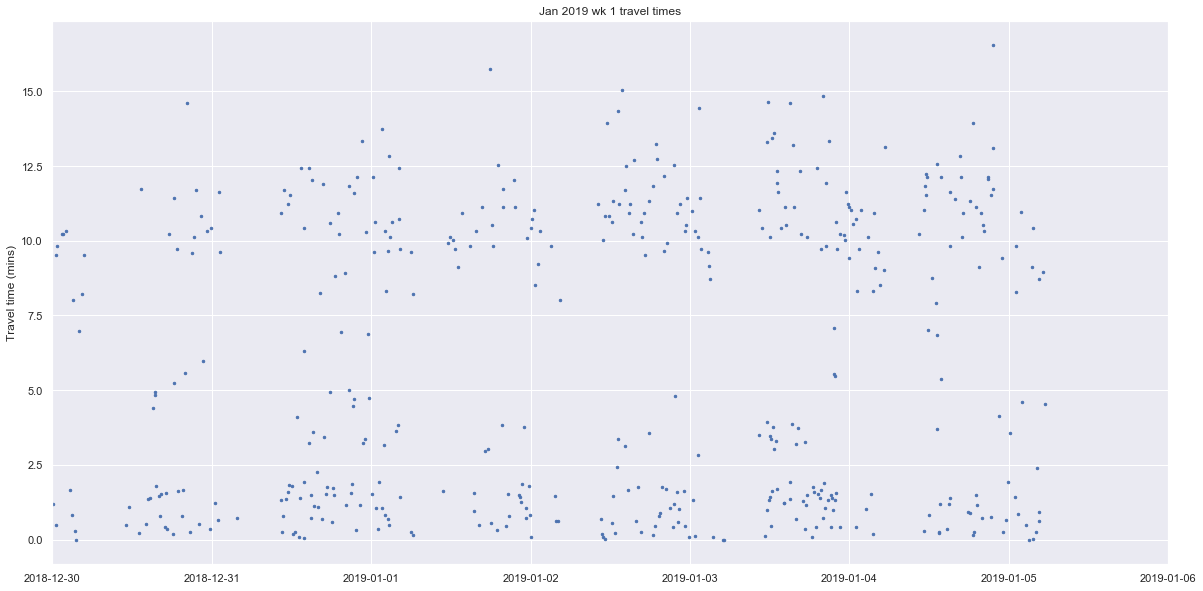

In [50]:
fig, ax = plt.subplots(figsize=(20,10))
plt.scatter(df_jan_1['dep_dt'], y=df_jan_1['travel_time_sec']/60, s=6)
plt.title('Jan 2019 wk 1 travel times')
# plt.xticks(np.arange(min(df_jan_1.dep_dt), max(df_jan_1.dep_dt)))
ax.set_xlim([pd.to_datetime(datelist_2019[0]), pd.to_datetime(datelist_2019[1])])
plt.ylabel('Travel time (mins)')
plt.show()

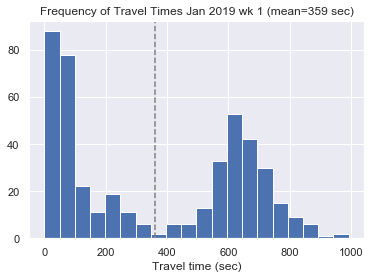

In [37]:
df_jan_1.travel_time_sec.hist(bins=20)
plt.title(f"Frequency of Travel Times Jan 2019 wk 1 (mean={int(np.mean(df_jan_1.travel_time_sec))} sec)")
plt.axvline(np.mean(df_jan_1.travel_time_sec),color='grey', linestyle='--')
plt.xlabel('Travel time (sec)')
plt.show()

In [38]:
plt.axvline?

In [39]:
df_jan_1.dtypes

route_id                             object
direction                            object
dep_dt                       datetime64[ns]
arr_dt                       datetime64[ns]
travel_time_sec                       int64
benchmark_travel_time_sec            object
dtype: object